## Accessing NAIP data with the Planetary Computer STAC API

The [National Agriculture Imagery Program](https://www.fsa.usda.gov/programs-and-services/aerial-photography/imagery-programs/naip-imagery/) (NAIP) provides US-wide, high-resolution aerial imagery, with four spectral bands (R, G, B, IR).  NAIP is administered by the [Aerial Field Photography Office](https://www.fsa.usda.gov/programs-and-services/aerial-photography/) (AFPO) within the [US Department of Agriculture](https://www.usda.gov/) (USDA).  Data are captured at least once every three years for each state.  This dataset represents NAIP data from 2010-present, in [cloud-optimized GeoTIFF](https://www.cogeo.org/) format.

This notebook demonstrates the use of the Planetary Computer STAC API to query for NAIP imagery.

### Environment setup

This notebook works with or without an API key, but you will be given more permissive access to the data with an API key.
The [Planetary Computer Hub](https://planetarycomputer.microsoft.com/compute) is pre-configured to use your API key.

In [1]:
%%capture
!pip install planetary_computer xarray-spatial xvec exactextract

In [2]:
import pystac_client
import planetary_computer
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray
import numpy as np
import matplotlib.pyplot as plt
import shapely
import xrspatial
import xvec
import dask
import warnings


# Set the environment variable PC_SDK_SUBSCRIPTION_KEY, or set it here.
# The Hub sets PC_SDK_SUBSCRIPTION_KEY automatically.
# pc.settings.set_subscription_key(<YOUR API Key>)

### Data access

In [3]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

### Choose our region and times of interest

In [4]:
region = [-13571302.7073,5853627.9860,-13418428.6507,5966199.5809]
damage = gpd.read_file("../data_working/damage_merged.gdb/", layer="merged")
damage = damage[~np.isnan(damage.PERCENT_MID)]
damage = damage.cx[region[0]:region[2], region[1]:region[3]]
damage.head()

,SURVEY_YEAR,DCA_CODE,DAMAGE_TYPE_CODE,PERCENT_MID,SEVERITY,geometry
662320,2018,11050,2,7.0,7,"MULTIPOLYGON (((-13480153.902 5860035.732, -13..."
662324,2018,11050,2,7.0,7,"MULTIPOLYGON (((-13469458.329 5879651.246, -13..."
662336,2018,11015,2,7.0,7,"MULTIPOLYGON (((-13487108.634 5872021.197, -13..."
662338,2018,11015,2,7.0,7,"MULTIPOLYGON (((-13487300.499 5858888.614, -13..."
662388,2018,11002,2,7.0,7,"MULTIPOLYGON (((-13487010.302 5865339.502, -13..."


In [5]:
def naip_item_datetime(item):
    '''
    Retrieve datetime for when this item was captured.
    '''
    return pd.to_datetime(item.properties["datetime"])

def area_of_overlap(item, geometry):
    target_area = geometry.area
    overlap_area = shapely.geometry.box(*item.properties["proj:bbox"]).intersection(geometry).area
    return overlap_area / target_area

def plot_naip_with_geometry(item, geometry, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    ds = rioxarray.open_rasterio(item.assets["image"].href)\
        .rio.clip_box(*geometry.bounds)\
        .sel(band=[1, 2, 3])
    ds.plot.imshow(ax=ax, interpolation="nearest")
    gpd.GeoSeries(geometry).plot(ax=ax, facecolor="none", edgecolor="red")
    ax.set_aspect("equal", "box")
    ax.set_title(item.properties["datetime"])
    return ax

def before_after_images(geometry, year, collection=None):
    '''
    Find NAIP assets that overlap with geometry before and after
    ``year``. If an image exists coincident with ``year``, that is always
    considered the "after" image.
    '''
    if collection is None:
        # Determine bounding box
        aoi = shapely.geometry.box(*gpd.GeoSeries(geometry).to_crs(4326).total_bounds)
    
        # Determine what years are in this region
        collection = catalog.search(
            collections=["naip"], intersects=aoi
        ).item_collection()

    avail_years = np.array(list(set(
        int(item.properties["datetime"][:4])
        for item in collection
    )))
    avail_years.sort()

    # Determine what year should serve as before/after
    i = np.searchsorted(avail_years, year)
    year_before = avail_years[i-1]
    year_after  = avail_years[i]

    # Filter to these years
    items_before = list(filter(
        lambda x: naip_item_datetime(x).year == year_before,
        collection
    ))
    items_after = list(filter(
        lambda x: naip_item_datetime(x).year == year_after,
        collection
    ))

    # Isolate items that have max overlap with the geometry
    # First reproject the geometry
    geom_proj = gpd.GeoSeries(geometry).to_crs(all_items[0].properties["proj:code"]).iloc[0]
    item_before = sorted(items_before, key=lambda x: area_of_overlap(x, geom_proj), reverse=True)[0]
    item_after  = sorted(items_after, key=lambda x: area_of_overlap(x, geom_proj), reverse=True)[0]

    return item_before, item_after
    

def before_after_plot(geometry, year, **fig_kwargs):
    '''
    Plot NAIP clip for damage polygon before and after/same year
    damage was observed.
    '''
    # Get images
    item_before, item_after = before_after_images(geometry, year)

    # Project the geometry
    geom_proj = gpd.GeoSeries(geometry).to_crs(item_before.properties["proj:code"]).iloc[0]

    # Now prepare the plot
    fig, (ax1, ax2) = plt.subplots(1, 2, **fig_kwargs)
    plot_naip_with_geometry(item_before, geom_proj, ax=ax1)
    plot_naip_with_geometry(item_after, geom_proj, ax=ax2)

    return fig, (ax1, ax2)

In [6]:
import gc

def naip_ndvi(nir, red):
    return ((nir - red) / (nir + red)).clip(-1, 1)

def before_after_ndvi(geometry, before, after):
    '''
    Mean NDVI of two images. Assumes that geometry
    is already in the same projection as the items.
    '''
    # Clip
    before_ds = rioxarray.open_rasterio(before.assets["image"].href)\
        .rio.clip_box(*geometry.total_bounds)

    after_ds  = rioxarray.open_rasterio(after.assets["image"].href)\
        .rio.clip_box(*geometry.total_bounds)

    # Calc NDVI
    before_ndvi = naip_ndvi(before_ds.sel(band=4), before_ds.sel(band=1))
    after_ndvi  = naip_ndvi(after_ds.sel(band=4), after_ds.sel(band=1))

    # zonal_stats needs a coordinate other than x/y to work.
    before_ndvi = before_ndvi.assign_coords(date=naip_item_datetime(before)).expand_dims(dim="date")
    after_ndvi  = after_ndvi.assign_coords(date=naip_item_datetime(after)).expand_dims(dim="date")

    # Exact extract is about 90% faster than rasterize
    before_zs = before_ndvi.xvec.zonal_stats(
        geometry,
        "x", "y",
        stats=["mean", "stdev", "count"],
        method="exactextract"
    )

    after_zs = after_ndvi.xvec.zonal_stats(
        geometry,
        "x", "y",
        stats=["mean", "stdev", "count"],
        method="exactextract"
    )

    # Combine ZS arrays and cleanup
    zs_ds = xr.Dataset({"ndvi_before": before_zs, "ndvi_after": after_zs})\
        .reset_index("geometry", drop=True)\
        .reindex(geometry=geometry.index)\
        .drop_vars("index")

    before_ds.close()
    after_ds.close()
    del before_ds, after_ds, before_ndvi, after_ndvi

    gc.collect()

    return zs_ds

In [7]:
total_aoi = shapely.geometry.box(*damage.geometry.to_crs(4326).total_bounds)
all_naip_items = catalog.search(
    collections=["naip"], intersects=total_aoi
).item_collection()

projections = set(i.properties["proj:code"] for i in all_naip_items)
available_years = set(naip_item_datetime(i).year for i in all_naip_items)

print("Found {} NAIP items".format(len(all_naip_items)))
print("Projections:", projections)
print("Available years:", available_years)

Found 1676 NAIP items
Projections: {'EPSG:26910'}
Available years: {2017, 2019, 2021, 2023, 2011, 2013, 2015}


In [8]:
damage_with_images = damage[damage.SURVEY_YEAR.isin(available_years)]

In [9]:
def worker_driver(geometry, year):
    warnings.filterwarnings("ignore", category=FutureWarning, message="Neither osr.UseExceptions()")
    import xvec
    # Filter to items that match this year
    # Nearest prior acquisition is always two years prior
    images_after  = list(filter(lambda x: naip_item_datetime(x).year == year,   all_naip_items))
    images_before = list(filter(lambda x: naip_item_datetime(x).year == year-2, all_naip_items))

    if len(images_after) == 0:
        print("No images found in {}".format(year))
        return None

    # Project the geometry
    geometry = gpd.GeoSeries(geometry)\
        .set_crs(damage_with_images.crs)\
        .to_crs(images_after[0].properties["proj:code"])

    # Determine item with best overlap
    item_after  = sorted(images_after, key=lambda x: area_of_overlap(x, geometry).iloc[0], reverse=True)[0]
    item_before = sorted(images_before, key=lambda x: area_of_overlap(x, geometry).iloc[0], reverse=True)[0]

    if area_of_overlap(item_after, geometry).iloc[0] < 0.5:
        #print("Insufficient overlap")
        return None

    # Get ZS
    return before_after_ndvi(geometry, item_before, item_after)

In [ ]:
from dask.distributed import Client, LocalCluster, progress

# Silence warnings about restarting workers
dask.config.set({"logging.distributed": "error"})
dask.config.set(scheduler="threads")

client = Client(
    threads_per_worker=1, 
    n_workers=12, 
    memory_limit="3 GiB", 
    lifetime="3 minutes", 
    lifetime_restart=True,
    lifetime_stagger="2 minutes"
)

lazy_zs = []
for i in range(damage_with_images.shape[0]):
    this_lazy_zs = dask.delayed(worker_driver)(
        damage_with_images.geometry.iloc[[i]],
        damage_with_images.SURVEY_YEAR.iloc[i]
    )
    lazy_zs.append(this_lazy_zs)

client

2025-05-19 20:02:06,290 - distributed.nanny - WARNING - Restarting worker
2025-05-19 20:02:19,478 - distributed.nanny - WARNING - Restarting worker
2025-05-19 20:02:24,190 - distributed.nanny - WARNING - Restarting worker
2025-05-19 20:04:39,378 - distributed.nanny - WARNING - Restarting worker
2025-05-19 20:05:50,821 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:33719 (pid=2381) exceeded 95% memory budget. Restarting...
2025-05-19 20:05:50,937 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:33719' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {'worker_driver-dfcceea4-b9a0-47fc-a59d-919f0c965952', 'worker_driver-b3ffe514-6e05-4078-a5d4-c8b514788bc5', 'worker_driver-a553c26b-8415-406d-b332-9aa2453bcd40', 'worker_driver-c627508b-227e-4c2f-bcc8-b6e01a4109ed', 'worker_driver-db45099b-ab91-4a31-9da3-a03f3e5d7b97', 'worker_driver-fe6dfad9-523d-44c3-8b8a-bc67157b3908', 'worker_driver-b12d7950-aa90-4b12-9f67-03927e

In [11]:
results = client.compute(lazy_zs, retries=3)

2025-05-19 19:43:09,724 - distributed.worker - ERROR - Compute Failed
Key:       worker_driver-fd0a29bf-356e-4726-8e14-3fabb2d1a0a2
State:     executing
Task:  <Task 'worker_driver-fd0a29bf-356e-4726-8e14-3fabb2d1a0a2' worker_driver(...)>
Exception: "NoDataInBounds('No data found in bounds.')"
Traceback: '  File "/tmp/ipykernel_279/3709387155.py", line 27, in worker_driver\n  File "/tmp/ipykernel_279/4103681715.py", line 12, in before_after_ndvi\n  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/rioxarray/raster_array.py", line 826, in clip_box\n    raise NoDataInBounds(\n'

2025-05-19 19:43:15,404 - distributed.worker - ERROR - Compute Failed
Key:       worker_driver-fb724d3a-f454-4038-a7fb-37087fd0d342
State:     executing
Task:  <Task 'worker_driver-fb724d3a-f454-4038-a7fb-37087fd0d342' worker_driver(...)>
Exception: "NoDataInBounds('No data found in bounds.')"
Traceback: '  File "/tmp/ipykernel_279/3709387155.py", line 27, in worker_driver\n  File "/tmp/ipykernel_279/41

In [14]:
def get_result(r):
    try:
        return r.result()
    except:
        return None

zs_results = [get_result(r) for r in results]

In [15]:
client.close()

In [19]:
zs_no_missing = list(filter(lambda x: x is not None, zs_results))

In [20]:
print(f"Initial tasks: {len(zs_results)}")
print(f"Succeeded: {len(zs_no_missing)}")
print(f"Failed: {len(zs_results) - len(zs_no_missing)}")

Initial tasks: 1528
Succeeded: 1303
Failed: 225


In [21]:
zs_df = pd.concat([zs.to_dataframe().reset_index() for zs in zs_no_missing])
zs_df.head()

,date,zonal_statistics,geometry,ndvi_before,ndvi_after
0,2017-07-24 00:00:00+00:00,mean,674368,0.613477,NaN
1,2017-07-24 00:00:00+00:00,stdev,674368,0.233606,NaN
2,2017-07-24 00:00:00+00:00,count,674368,50386.598429,NaN
3,2019-08-03 00:00:00+00:00,mean,674368,NaN,0.506092
4,2019-08-03 00:00:00+00:00,stdev,674368,NaN,0.310450


In [35]:
zs_df_melt = zs_df.melt(
    id_vars=["date", "zonal_statistics", "geometry"], 
    value_vars=["ndvi_before", "ndvi_after"],
    var_name="var",
    value_name="value"
).dropna().replace({"var": {"ndvi_before": "before", "ndvi_after": "after"}})

In [36]:
zs_df_melt[zs_df_melt.geometry == 674368]

,date,zonal_statistics,geometry,var,value
0,2017-07-24 00:00:00+00:00,mean,674368,before,0.613477
1,2017-07-24 00:00:00+00:00,stdev,674368,before,0.233606
2,2017-07-24 00:00:00+00:00,count,674368,before,50386.598429
7821,2019-08-03 00:00:00+00:00,mean,674368,after,0.506092
7822,2019-08-03 00:00:00+00:00,stdev,674368,after,0.310450
7823,2019-08-03 00:00:00+00:00,count,674368,after,139960.773411


In [37]:
zs_df_melt["stat"] = zs_df_melt["var"] + "_" + zs_df_melt["zonal_statistics"]
zs_df_melt.drop(columns=["zonal_statistics", "var"], inplace=True)
zs_df_melt[zs_df_melt.geometry == 674368]

,date,geometry,value,stat
0,2017-07-24 00:00:00+00:00,674368,0.613477,before_mean
1,2017-07-24 00:00:00+00:00,674368,0.233606,before_stdev
2,2017-07-24 00:00:00+00:00,674368,50386.598429,before_count
7821,2019-08-03 00:00:00+00:00,674368,0.506092,after_mean
7822,2019-08-03 00:00:00+00:00,674368,0.310450,after_stdev
7823,2019-08-03 00:00:00+00:00,674368,139960.773411,after_count


In [47]:
zs_df_pivot = zs_df_melt.pivot_table(values="value", columns="stat", index=["geometry"])
zs_df_join = zs_df_pivot.join(damage_with_images.drop(columns="geometry"))
zs_df_join.head()

,after_count,after_mean,after_stdev,before_count,before_mean,before_stdev,SURVEY_YEAR,DCA_CODE,DAMAGE_TYPE_CODE,PERCENT_MID,SEVERITY
geometry,,,,,,,,,,,
674368,139960.773411,0.506092,0.310450,50386.598429,0.613477,0.233606,2019,11050,2,7.0,7
674371,110292.166458,0.603828,0.192631,39705.539925,0.763277,0.199679,2019,11050,2,2.0,2
674382,37113.738288,0.578747,0.383521,13362.025784,0.505517,0.285505,2019,11050,2,2.0,2
674436,198295.322417,0.456314,0.290477,71387.036072,0.696941,0.152495,2019,11050,2,2.0,2
674490,117159.260859,0.469399,0.301044,42177.333909,0.597369,0.182917,2019,11050,2,2.0,2


In [48]:
zs_df_join["delta_ndvi"] = zs_df_join["after_mean"] - zs_df_join["before_mean"]

<Axes: title={'center': 'delta_ndvi'}, xlabel='SEVERITY'>

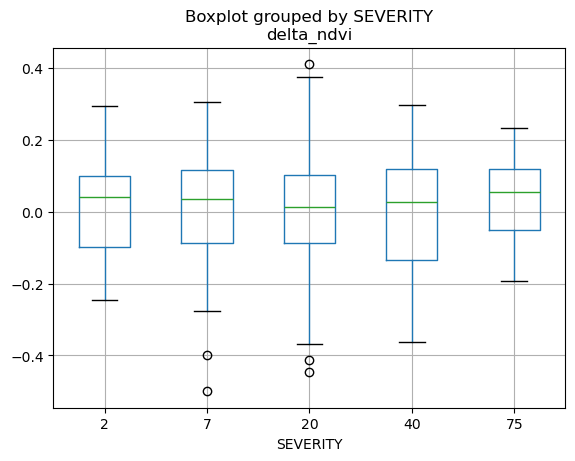

In [50]:
zs_df_join.boxplot("delta_ndvi", by="SEVERITY")

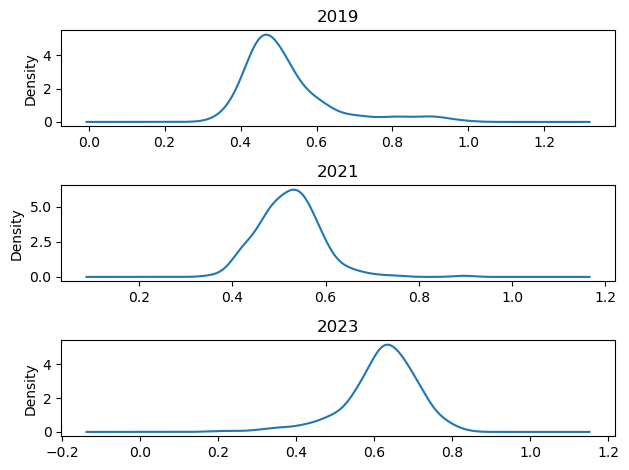

In [56]:
survey_years = zs_df_join["SURVEY_YEAR"].unique()
fig, axes = plt.subplots(len(survey_years), 1)
for (ax, y) in zip(axes, survey_years):
    zs_df_join[zs_df_join.SURVEY_YEAR == y]["after_mean"].plot.kde(ax=ax)
    ax.set_title(y)

fig.tight_layout()
plt.show()

<Axes: title={'center': 'delta_ndvi'}, xlabel='SEVERITY'>

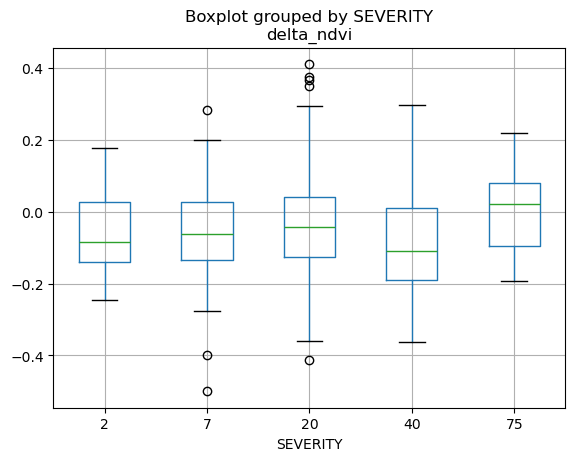

In [57]:
zs_df_join[zs_df_join.SURVEY_YEAR != 2023].boxplot("delta_ndvi", by="SEVERITY")

In [58]:
zs_df_join.to_csv("../data_working/NAIP_summer_ndvi_cougar_valley.csv")